In [14]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time
from scipy.optimize import curve_fit

In [15]:
print(np.pi)

3.141592653589793


9.738987266769944e-05
numerical goodness_of_fit= 1.8100720153547845e-05


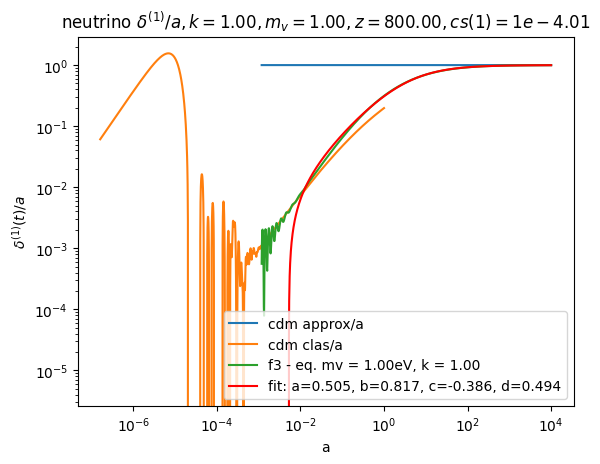

In [16]:
def TEST(kvec=[1],k_ind=0,z=800,mv_test=1,Omega_M=0.99,
         Omega_b=0.01,PLOT_FIGUR=True,EdSitter=True,
         interpolation_type="cubic",H0_override=False,H=67):

    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    H0=67
    
    if H0_override == True:
        H0 =H
    
    # CLASS stuff
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    c = cs(1)
    print(c)
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    
    def simuler(z_slut=0): 
        
        delta_approx = np.empty(len(kvec))
        neu_list     = np.empty(len(kvec)) 
        
        for kind,k in enumerate(kvec): 
            delta_class = pts[kind]["delta_cdm"]
            theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
            delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
            a_class = pts[kind]["a"]
            tau_class = pts[kind]["tau [Mpc]"]
            tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
            interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
            delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
            theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
            neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
            a0 = 1/(1+z)
            aslut = 1/(1+z_slut)
            # så a0 er a start men t0 er tid slut
            t0 = interp_tid_from_a(aslut) 
            #print("2. t0= %s"%t0)
            a_span = [a0,aslut]
            T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
            delta0 = delta_interp(T0)  
            tspan = [T0,t0]        
            def f2(t):
                C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
                C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
                dcdm = delta0/a0        
                a = (t/t0)**(2/3)
                val = 3 * cs(a) * k * t0 * np.sqrt(a)        
                return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
            delta_approx[kind] = delta0/a0 * aslut
            neu_list[kind] = f2(t0)
        
        logkvec = np.log10(kvec)
        def p2(delta, k):
            return 2 * np.pi ** 2 * delta**2 *  prim_interp(k) * h**3 *  k**(-3)

        p_approx_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_approx, kvec)), kind=interpolation_type)
        def p_approx(k):
            return 10** p_approx_interp(np.log10(k))


        p_neu_lig_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(neu_list, kvec)), kind=interpolation_type)
        def p_neu_lig(k):
            return 10** p_neu_lig_interp(np.log10(k))

    
        return p_approx,p_neu_lig
     
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
        
    def Bispektrum(k1,t,theta,p):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3           
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res        
    
 
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        # så a0 er a start men t0 er tid slut
        t0 = interp_tid_from_a(aslut)
        #print("2. t0= %s"%t0)
        a_span = [a0,aslut]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]    
        bonus_tid = 1_000_000#_000_000
        #bonus_tid = 1
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),1200)
        def f2(t):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) +val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            return res        
        def f3(t):
            H0 = 2/(3*t0)                   
            a = (t/t0)**(2/3)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0             
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
            return res
        
        def f2(a):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) +val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            return res        
        def f3(a):
            H0 = 2/(3*t0)                   
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0             
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
            return res
         
        a_test = (tid_test/t0)**(2/3) 
        fig = plt.figure()
        fig.gca().set_title("neutrino $\delta^{(1)}/a, k = %.2f, m_v=%.2f,z=%.2f, cs(1)=1e%.2f$" %(kvec[k_ind],mv_test,z,np.log10(cs(1))))
        #fig.gca().set_xlabel("Physical time [Mpc]")
        fig.gca().set_xlabel("a")
        fig.gca().set_ylabel("$\delta^{(1)}(t)/a$")
        tid_test = np.array(tid_test)
        f4 = np.array(f3(a_test)/(delta0/a0))
        
        """fig.gca().loglog(tid_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(tid_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(tid_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        """
        
        fig.gca().loglog(a_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(a_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(a_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        coordinates = np.vstack([tid_test,f4]).T 
        xdata = a_test
        ydata = f4
        def func(x, a, b, c,d):
            return a * np.tanh(b * x + c) + d
        #plt.plot(xdata, ydata, 'b-', label='data')
        p0 = np.array([-0.5,-.5,cs(1),1])#0.502])
        popt, pcov = curve_fit(func, np.log10(xdata), (ydata))#,p0=p0)
        #popt[-1] += 1e-4
        #plt.loglog(xdata, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.loglog(a_test, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        goodness_of_fit = np.mean((ydata- func(np.log10(xdata), *popt))**2)
        print("numerical goodness_of_fit= %s" % goodness_of_fit)
        #goodness_of_fit = np.mean((ydata- func(np.log10(xdata), *[]))**2)
        plt.legend() 
    test(0)
    
    #plt.legend(loc=(1.05, 0.5))
     
    
kvec1 = [1]#list(np.logspace(-4,1,10))  
TEST(kvec = kvec1,mv_test=1,) 

0.0009738987266769944
numerical goodness_of_fit= 1.6828013265850385e-05


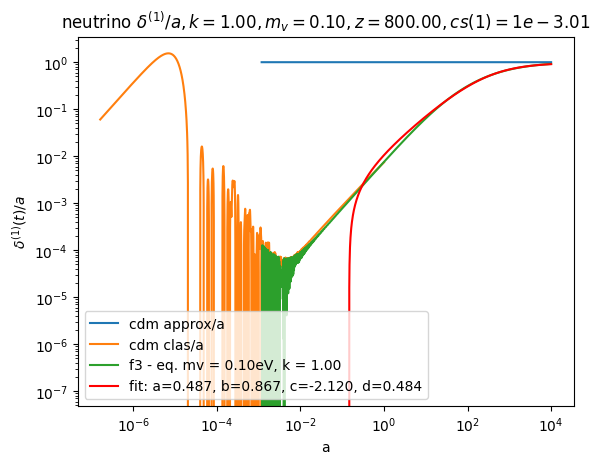

In [63]:
TEST(kvec = kvec1,mv_test=.1,) 

9.738987266769944e-05
numerical goodness_of_fit= 3.768616604802376e-05


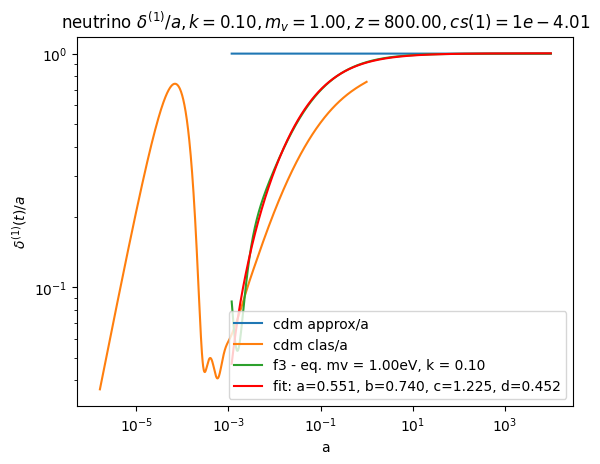

In [64]:
kvec1 = [.1] 
TEST(kvec = kvec1,mv_test=1,) 

0.0009738987266769944
numerical goodness_of_fit= 2.0045645703223988e-05


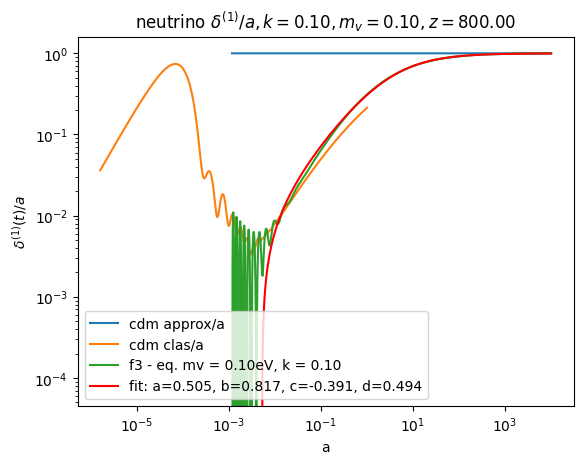

In [54]:
TEST(kvec = kvec1,mv_test=.1,) 

0.0032463290889233145
numerical goodness_of_fit= 3.5653434162566316e-11


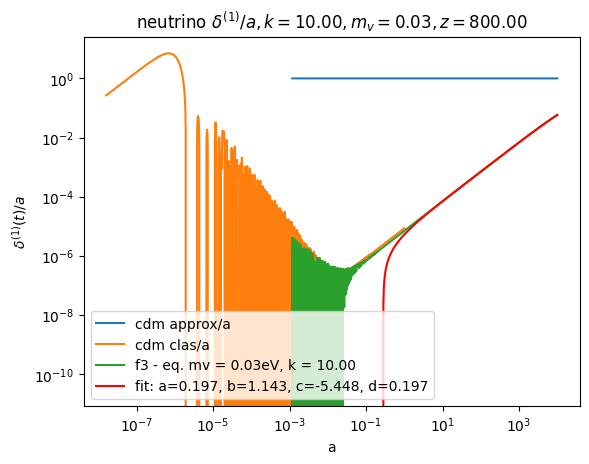

In [55]:
TEST(kvec=[10],mv_test=.03)

0.0009738987266769944
numerical goodness_of_fit= 9.60580575257332e-08


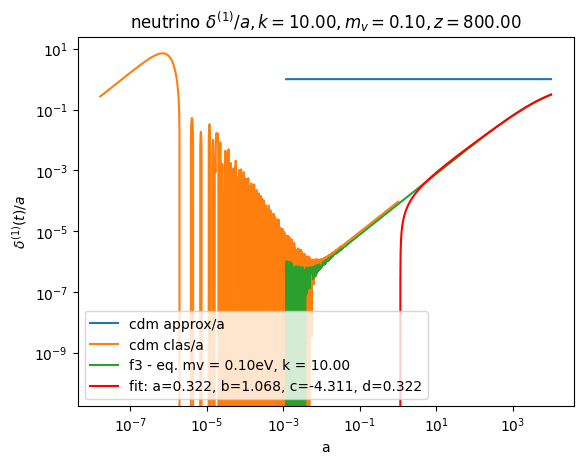

In [56]:
TEST(kvec=[10],mv_test=.1)

0.00019477974533539888
numerical goodness_of_fit= 8.552818041843061e-06


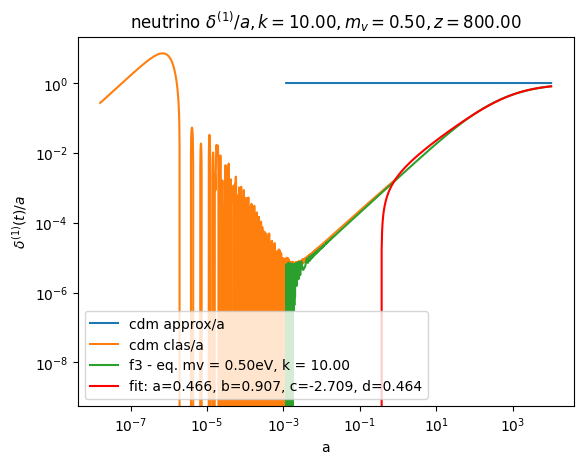

In [57]:
TEST(kvec=[10],mv_test=.5)

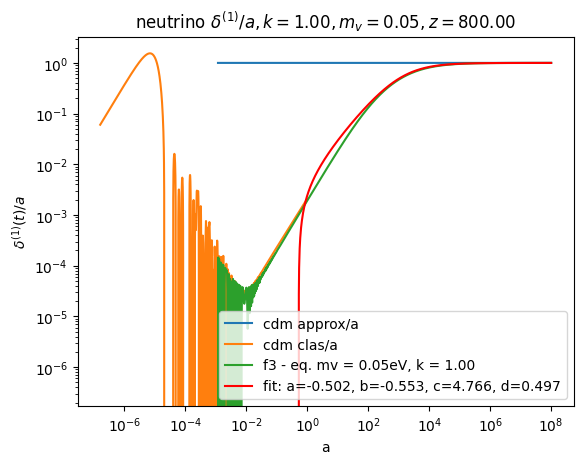

In [20]:
TEST(kvec=[1],mv_test=.05)

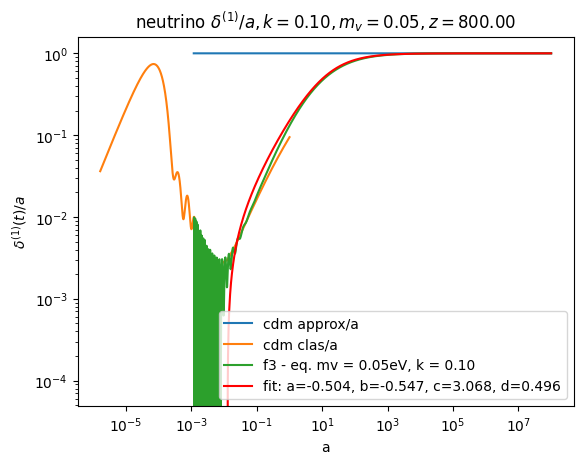

In [21]:
TEST(kvec=[.1],mv_test=.05)

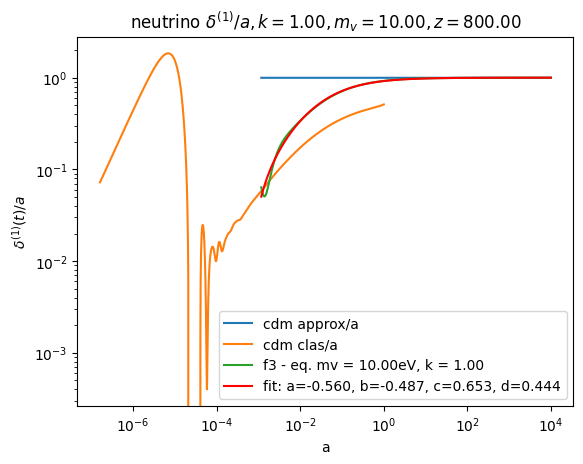

In [17]:
def TEST1(kvec=[1],k_ind=0,z=800,
         mv_test=1,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,
         interpolation_type="cubic",
         H0_override=False,
         H =67 ):

    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    H0=67
    # CLASS stuff
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    if H0_override == True:
        H0 = h
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    c = cs(1)
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    
    def simuler(z_slut=0): 
        
        delta_approx = np.empty(len(kvec))
        neu_list     = np.empty(len(kvec)) 
        
        for kind,k in enumerate(kvec): 
            delta_class = pts[kind]["delta_cdm"]
            theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
            delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
            a_class = pts[kind]["a"]
            tau_class = pts[kind]["tau [Mpc]"]
            tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
            interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
            delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
            theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
            neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
            a0 = 1/(1+z)
            aslut = 1/(1+z_slut)
            # så a0 er a start men t0 er tid slut
            t0 = interp_tid_from_a(aslut) 
            #print("2. t0= %s"%t0)
            a_span = [a0,aslut]
            T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
            delta0 = delta_interp(T0)  
            tspan = [T0,t0]        
            def f2(t):
                C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
                C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
                dcdm = delta0/a0        
                a = (t/t0)**(2/3)
                val = 3 * cs(a) * k * t0 * np.sqrt(a)        
                return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
            delta_approx[kind] = delta0/a0 * aslut
            neu_list[kind] = f2(t0)
        
        logkvec = np.log10(kvec)
        def p2(delta, k):
            return 2 * np.pi ** 2 * delta**2 *  prim_interp(k) * h**3 *  k**(-3)

        p_approx_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_approx, kvec)), kind=interpolation_type)
        def p_approx(k):
            return 10** p_approx_interp(np.log10(k))


        p_neu_lig_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(neu_list, kvec)), kind=interpolation_type)
        def p_neu_lig(k):
            return 10** p_neu_lig_interp(np.log10(k))

    
        return p_approx,p_neu_lig
     
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
        
    def Bispektrum(k1,t,theta,p):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3           
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res        
    
 
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        # så a0 er a start men t0 er tid slut
        t0 = interp_tid_from_a(aslut)
        #print("2. t0= %s"%t0)
        a_span = [a0,aslut]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]    
        bonus_tid = 1_000_000#_000_000
        #bonus_tid = 1
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),1200)
        def f2(t):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            #C2 =2* np.pi  * ( 3/2 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 3 * cs(a) * k * t0 * np.sqrt(a)     
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) +val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            gamma = 0.57721 
            return res
        
        def f3(t):
            H0 = 2/(3*t0)
            #H0 = H/3 *1e-5
            a = (t/t0)**(2/3)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0 
            
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP
            
            return res
         
        a_test = (tid_test/t0)**(2/3) 
        fig = plt.figure()
        fig.gca().set_title("neutrino $\delta^{(1)}/a, k = %.2f, m_v=%.2f,z=%.2f$" %(kvec[k_ind],mv_test,z))
        #fig.gca().set_xlabel("Physical time [Mpc]")
        fig.gca().set_xlabel("a")
        fig.gca().set_ylabel("$\delta^{(1)}(t)/a$")
        tid_test = np.array(tid_test)
        f4 = np.array(f3(tid_test)/(delta0/a0))
        
        """fig.gca().loglog(tid_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(tid_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(tid_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        """
        
        fig.gca().loglog(a_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(a_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(a_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        coordinates = np.vstack([tid_test,f4]).T
        
        with open('filename', 'w') as fh:
            for x, y in coordinates: 
                fh.write('{} {}\n'.format(x, y))
        X, Y = np.loadtxt('filename', delimiter=' ', unpack=True)
        xdata = X
        ydata = Y
        def func(x, a, b, c,d):
            return a * np.tanh(b * x + c) + d
        #plt.plot(xdata, ydata, 'b-', label='data')
        p0 = np.array([-0.5,-.5,2.5,1])#0.502])
        popt, pcov = curve_fit(func, np.log10(xdata), (ydata))#,p0=p0)
        popt[-1] += 1e-4
        #plt.loglog(xdata, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.loglog(a_test, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.legend()
       
    test(0)
    
TEST1(kvec = [1],mv_test=10) 

In [18]:
"""x = np.array(xlst[:-1])
y = np.array(ylst[:-1])
cs = np.array(cslst[:-1])
print(xlst,x)
print(ylst,y)
#plt.plot(ylst,xlst)
plt.scatter(x,y)
plt.plot(x,2/x)
plt.figure(0)
plt.scatter(x,cs)
plt.plot(x,1e-4/x)"""

NameError: name 'xlst' is not defined

700
0.0003065621759637571


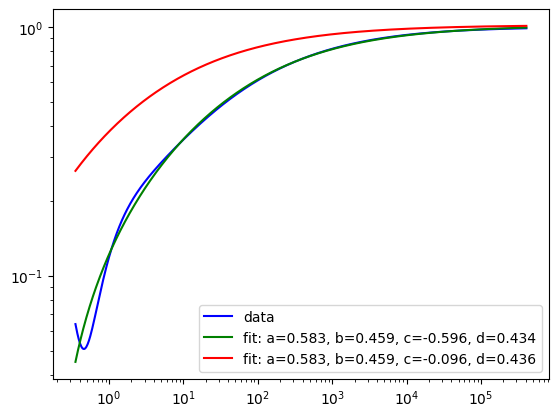

In [19]:
X, Y = np.loadtxt('filename', delimiter=' ', unpack=True)
M = 700
xdata = X[0:M]
print(len(xdata))
print(X[800]*1e-10)
ydata = Y[0:M]
def func(x, a, b, c,d):
    return a * np.tanh(b * x + c) + d
plt.plot(xdata, ydata, 'b-', label='data')
p0 = np.array([-0.5,-.5,2.5,0.502])
popt, pcov = curve_fit(func, np.log10(xdata), (ydata))#,p0=p0)
plt.loglog(xdata, func(np.log10(xdata), *popt), 'g-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
popt[0] += 0
popt[1] += 0
popt[2] += 0.5 
popt[3] += 10**(-2.65)
plt.loglog(xdata, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
plt.legend()

In [6]:
print(0.494+10**(-2.1))

0.5019432823472428


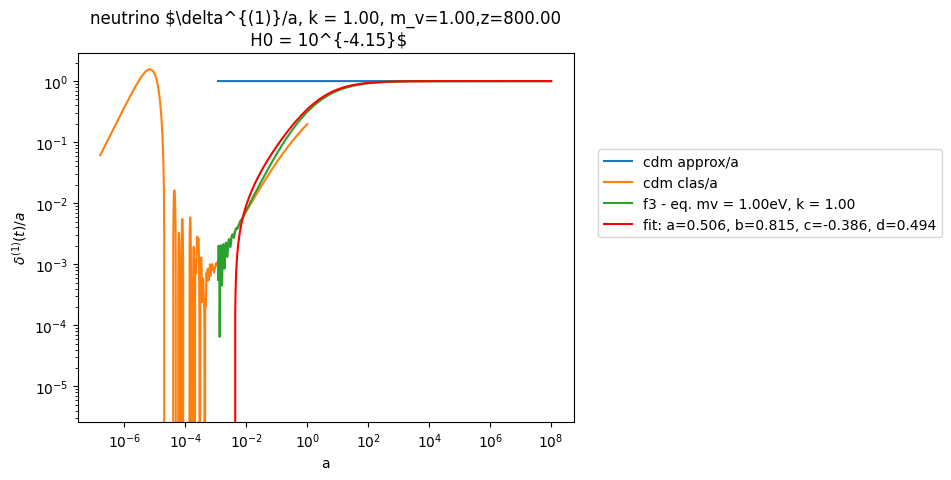

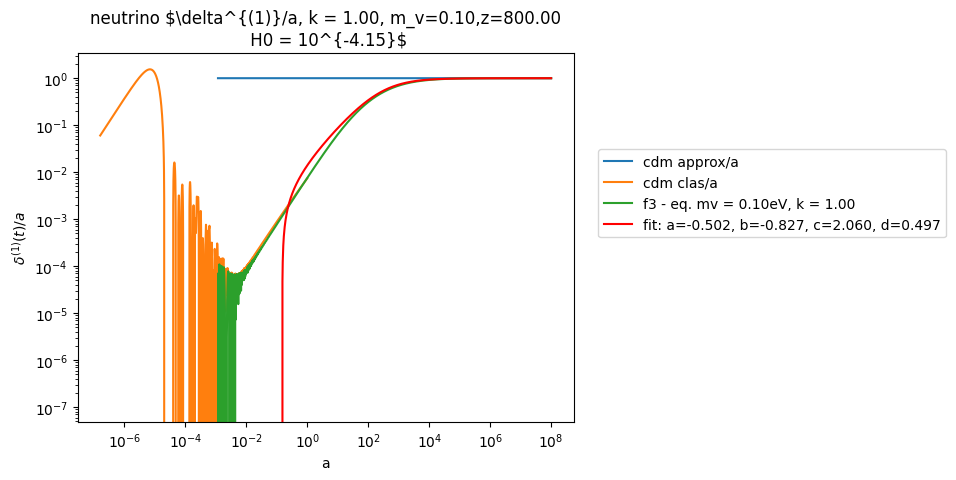

In [20]:

def TEST5(kvec=[1],k_ind=0,z=800,mv_test=1 ,Omega_M = 0.99,
         Omega_b=0.01,PLOT_FIGUR=True,
         EdSitter=True,interpolation_type="cubic"):

    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    # CLASS stuff
    H0=67
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc

    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    c = cs(1)
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    
    def simuler(z_slut=0): 
        
        delta_approx = np.empty(len(kvec))
        neu_list     = np.empty(len(kvec)) 
        
        for kind,k in enumerate(kvec): 
            delta_class = pts[kind]["delta_cdm"]
            theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
            delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
            a_class = pts[kind]["a"]
            tau_class = pts[kind]["tau [Mpc]"]
            tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
            interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
            delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
            theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
            neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
            a0 = 1/(1+z)
            aslut = 1/(1+z_slut)
            # så a0 er a start men t0 er tid slut
            t0 = interp_tid_from_a(aslut) 
            #print("2. t0= %s"%t0)
            a_span = [a0,aslut]
            T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
            delta0 = delta_interp(T0)  
            tspan = [T0,t0]        
            def f2(t):
                C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
                C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
                dcdm = delta0/a0        
                a = (t/t0)**(2/3)
                val = 3 * cs(a) * k * t0 * np.sqrt(a)        
                return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
            delta_approx[kind] = delta0/a0 * aslut
            neu_list[kind] = f2(t0)
        
        logkvec = np.log10(kvec)
        def p2(delta, k):
            return 2 * np.pi ** 2 * delta**2 *  prim_interp(k) * h**3 *  k**(-3)

        p_approx_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_approx, kvec)), kind=interpolation_type)
        def p_approx(k):
            return 10** p_approx_interp(np.log10(k))


        p_neu_lig_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(neu_list, kvec)), kind=interpolation_type)
        def p_neu_lig(k):
            return 10** p_neu_lig_interp(np.log10(k))

    
        return p_approx,p_neu_lig
     
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
        
    def Bispektrum(k1,t,theta,p):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3           
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res        
    
 
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        # så a0 er a start men t0 er tid slut
        t0 = interp_tid_from_a(aslut)
        #print("2. t0= %s"%t0)
        a_span = [a0,aslut]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]    
        bonus_tid = 1_000_000_000_000
        #bonus_tid = 1
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),1200)
        def f2(a):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            #C2 =2* np.pi  * ( 3/2 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            #a = (t/t0)**(2/3)
            #val = 3 * cs(a) * k * t0 * np.sqrt(a)     
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            #val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) +val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            gamma = 0.57721 
            return res
        
        def f3(a):
            H0 = 2/(3*t0)
                   
            #a = (t/t0)**(2/3)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0 
            
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP
            
            return res
         
        a_test = (tid_test/t0)**(2/3) 
        fig = plt.figure()
        logH0 = np.log10(2/(3*t0))
        fig.gca().set_title("neutrino $\delta^{(1)}/a, k = %.2f, m_v=%.2f,z=%.2f\n H0 = 10^{%.2f}$" %(kvec[k_ind],mv_test,z,logH0))
        #fig.gca().set_xlabel("Physical time [Mpc]")
        fig.gca().set_xlabel("a")
        fig.gca().set_ylabel("$\delta^{(1)}(t)/a$")
        tid_test = np.array(tid_test)
        f4 = np.array(f3(a_test)/(delta0/a0))
        
        """fig.gca().loglog(tid_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(tid_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(tid_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        """
        
        fig.gca().loglog(a_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(a_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(a_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        coordinates = np.vstack([a_test,f4]).T
        
        with open('filename', 'w') as fh:
            for x, y in coordinates: 
                fh.write('{} {}\n'.format(x, y))
        X, Y = np.loadtxt('filename', delimiter=' ', unpack=True)
        xdata = X
        ydata = Y
        
        def func(x, a, b, c,d):
            return a * np.tanh(b * x + c) + d
        #plt.plot(xdata, ydata, 'b-', label='data')
        p0 = np.array([-0.5,-.5,2.5,1])#0.502])
        popt, pcov = curve_fit(func, np.log10(xdata), (ydata))#,p0=p0)
        #plt.loglog(xdata, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.loglog(a_test, func(np.log10(xdata)+1e-1, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.legend() 
    test(0)
    
    plt.legend(loc=(1.05, 0.5))
     
    
kvec1 = [1]#list(np.logspace(-4,1,10))  
TEST5(kvec = kvec1,mv_test=1,) 
TEST5(kvec = kvec1,mv_test=.1,) 



700
2.306555195641275e-06
[0.5, 0.8, -9.484787298230709e-07, 0]


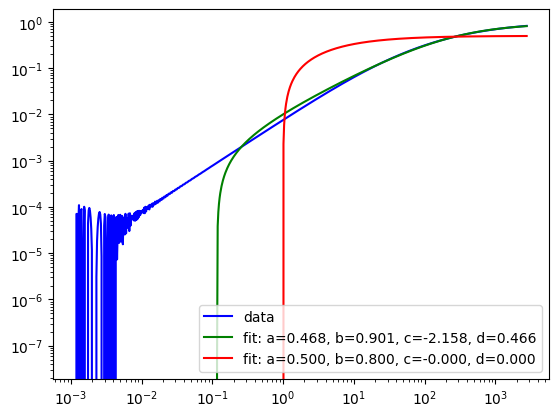

In [21]:
X, Y = np.loadtxt('filename', delimiter=' ', unpack=True)
M = 700
xdata = X[0:M]
print(len(xdata))
print(X[800]*1e-10)
ydata = Y[0:M]
def func(x, a, b, c,d):
    return a * np.tanh(b * x + c) + d
plt.plot(xdata, ydata, 'b-', label='data')
p0 = np.array([-0.5,-.5,2.5,0.502])
popt, pcov = curve_fit(func, np.log10(xdata), (ydata))#,p0=p0)
plt.loglog(xdata, func(np.log10(xdata), *popt), 'g-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
popt1 = [*popt[:]]
popt1[0] += 0
popt1[1] += 0
popt1[2] += 0.5 
popt1[3] += 10**(-0.78910015)
test = popt[:]
a0 = 1/801
mv_test = 0.1
def cs(a):
    Tv_k = 1.947 # kelvin # MeV
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    mv = mv_test * 1e-6
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 8
    return cs_factor *T_0 / a / mv
c = cs(1)
k = 1
H0 = 10**(-4.15)
test = [1/2,4/5 ,-c**2*k*k,0]
print(test)
plt.loglog(xdata, func(np.log10(xdata), *test), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(test))
#plt.plot(xdata, func(np.log10(xdata), *popt1), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
#plt.yscale("log")
#plt.xscale("log")
plt.legend()

9.738987266769944e-05
numerical goodness_of_fit= 1.8100720153547845e-05
9.738987266769944e-05
numerical goodness_of_fit= 2.2321519641356253e-05
9.738987266769944e-05
numerical goodness_of_fit= 2.3252375895159018e-05
9.738987266769944e-05
numerical goodness_of_fit= 2.304639824090626e-05
9.738987266769944e-05
numerical goodness_of_fit= 2.232763355591983e-05
9.738987266769944e-05
numerical goodness_of_fit= 2.1358778084772554e-05
9.738987266769944e-05
numerical goodness_of_fit= 2.027244461940358e-05


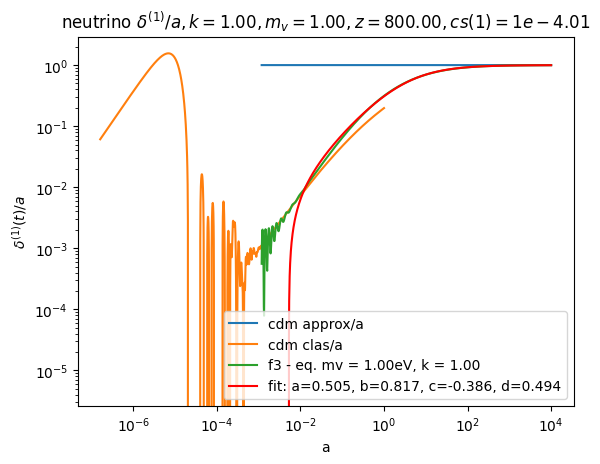

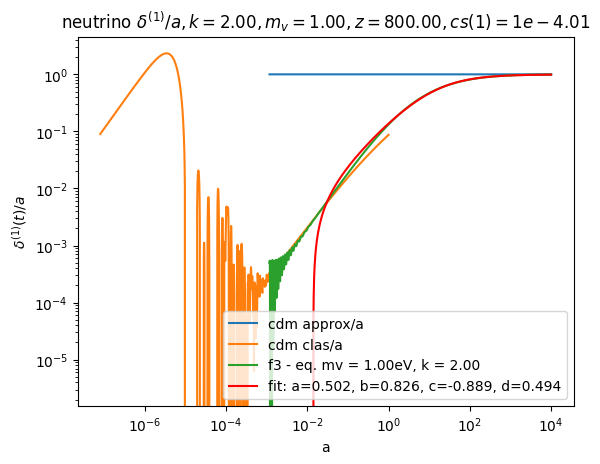

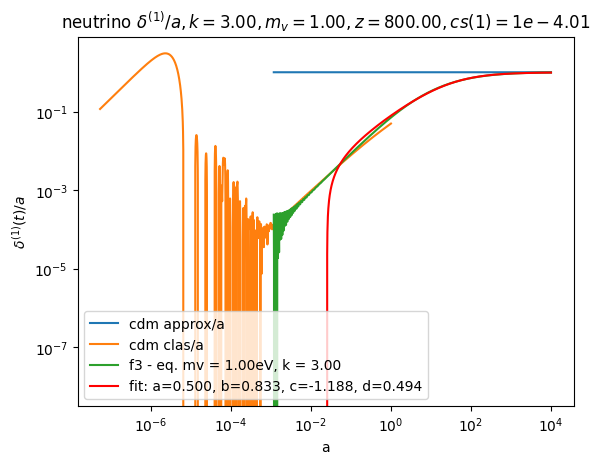

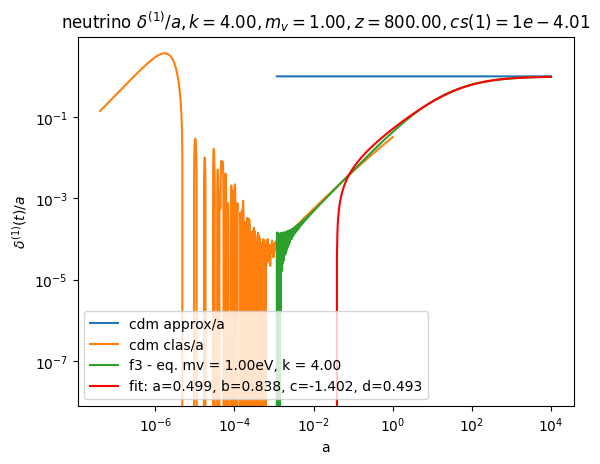

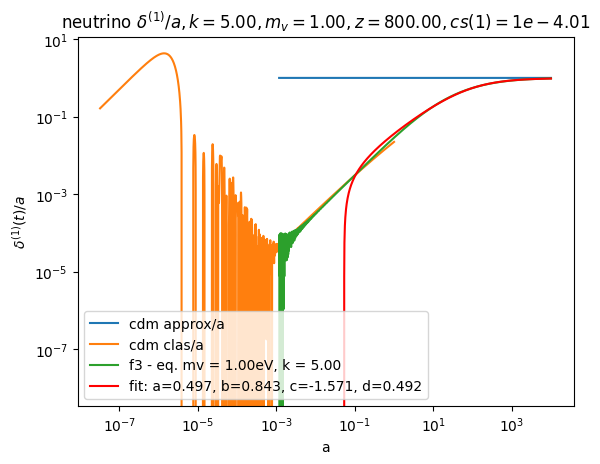

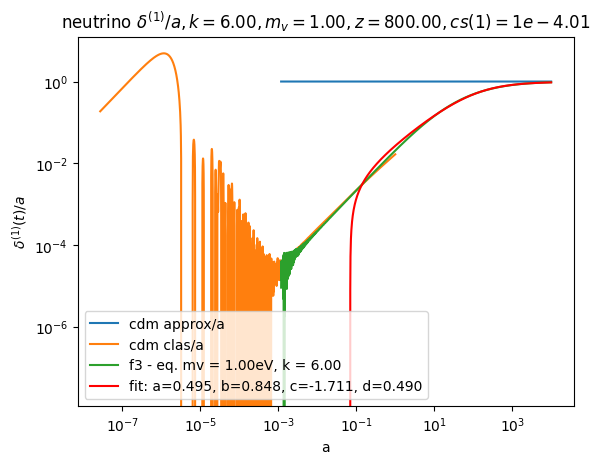

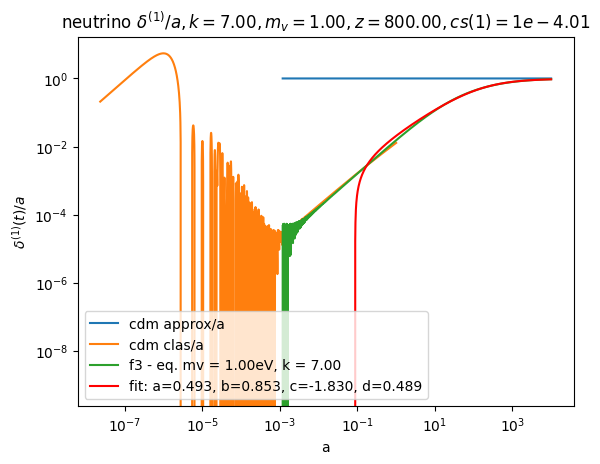

In [65]:
TEST(kvec = [1],mv_test=1,) 
TEST(kvec = [2],mv_test=1,) 
TEST(kvec = [3],mv_test=1,) 
TEST(kvec = [4],mv_test=1,) 
TEST(kvec = [5],mv_test=1,) 
TEST(kvec = [6],mv_test=1,) 
TEST(kvec = [7],mv_test=1,) 

9.738987266769944e-07
numerical goodness_of_fit= 1.544617451801631e-08
1.947797453353989e-06
numerical goodness_of_fit= 4.927779282793648e-06
9.738987266769944e-06
numerical goodness_of_fit= 3.555302244801622e-05
1.9477974533539888e-05
numerical goodness_of_fit= 1.1998257502523252e-05
9.738987266769944e-05
numerical goodness_of_fit= 1.8100720153547845e-05
0.00010821096963077715
numerical goodness_of_fit= 1.8885110980285566e-05
0.0001217373408346243
numerical goodness_of_fit= 1.9756571254664474e-05
0.0001391283895252849
numerical goodness_of_fit= 2.0630826385733505e-05
0.00016231645444616573
numerical goodness_of_fit= 2.1508304252692418e-05
0.00019477974533539888
numerical goodness_of_fit= 2.23373697632839e-05
0.0002434746816692486
numerical goodness_of_fit= 2.300521230881298e-05
0.00032463290889233145
numerical goodness_of_fit= 2.32648301014658e-05
0.0004869493633384972
numerical goodness_of_fit= 2.2300738736854102e-05
0.0009738987266769944
numerical goodness_of_fit= 1.6828013265850385

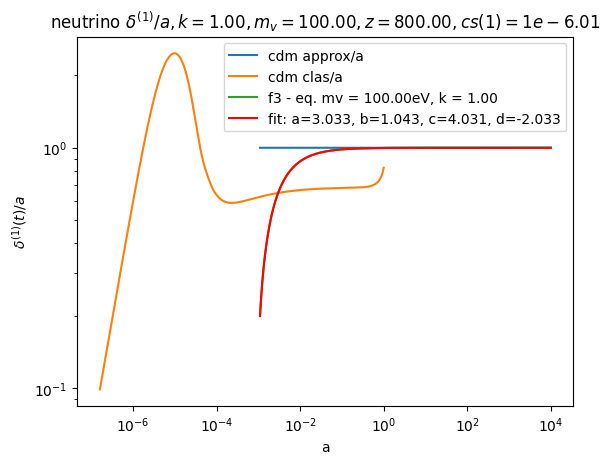

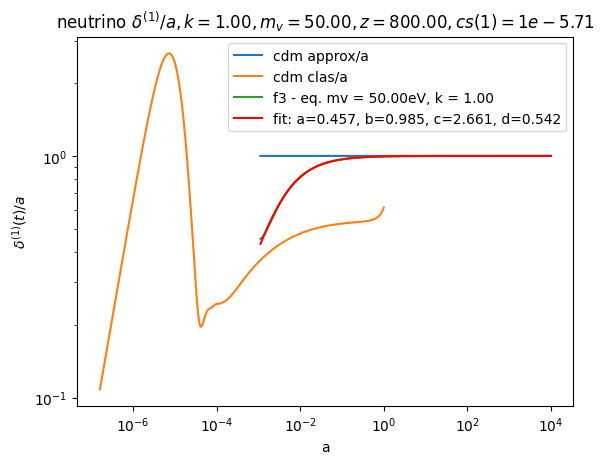

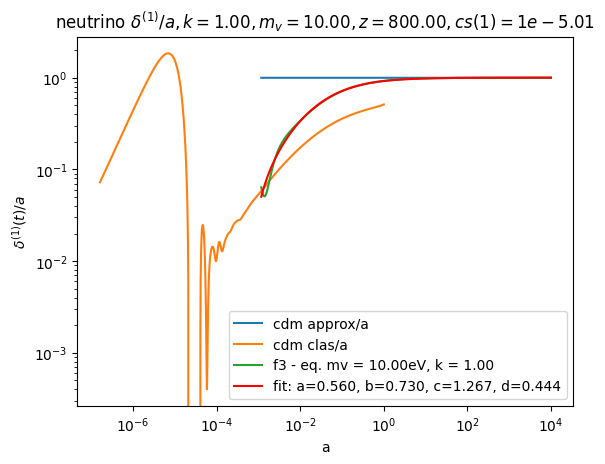

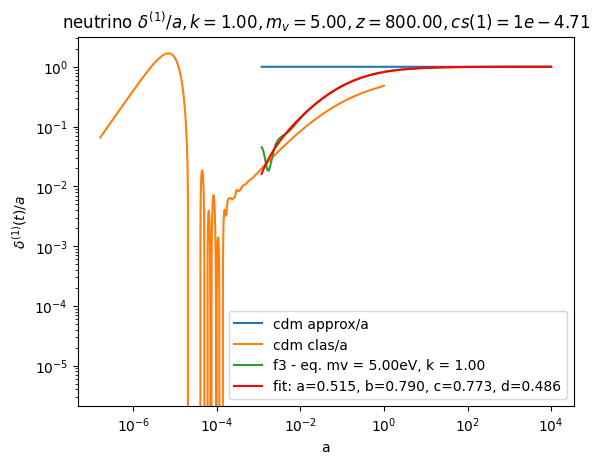

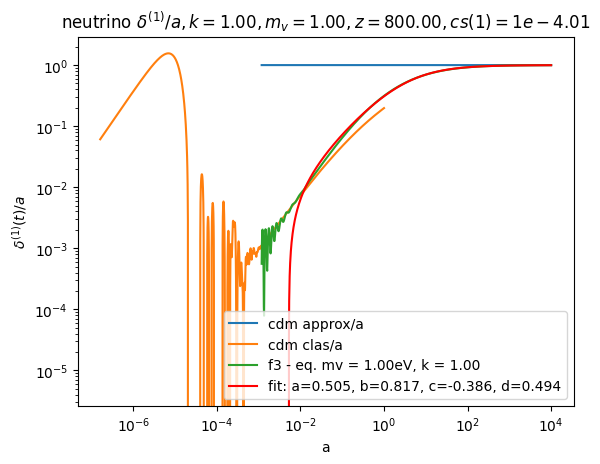

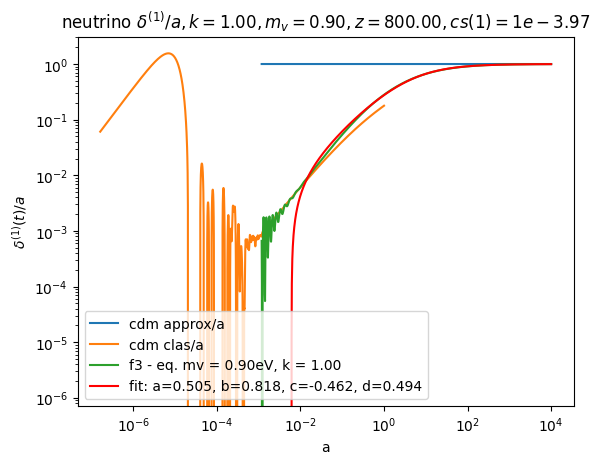

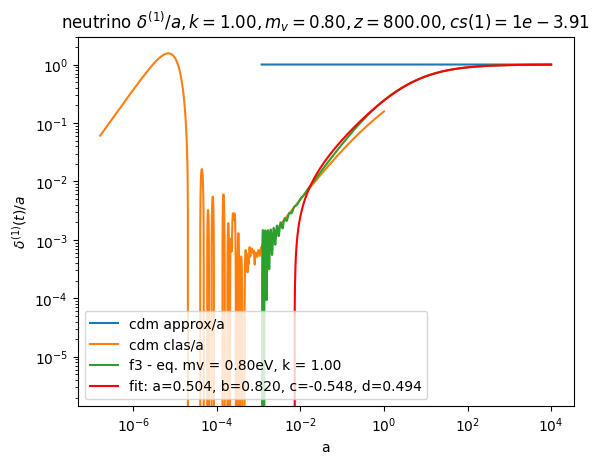

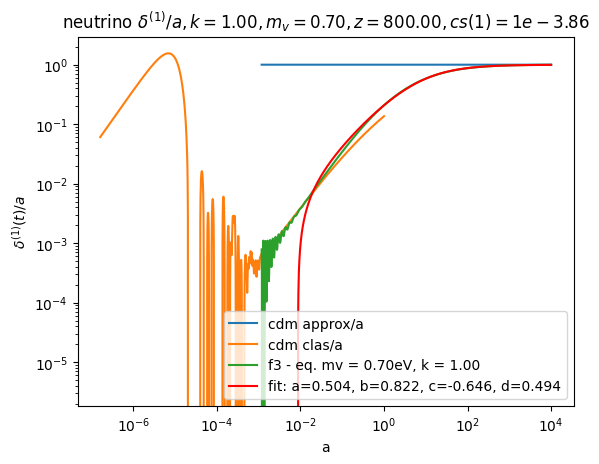

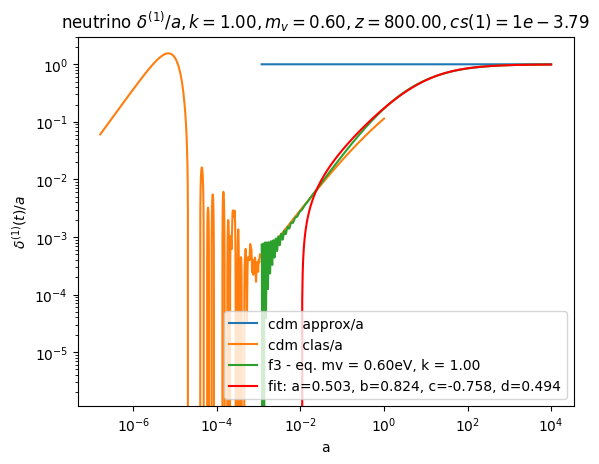

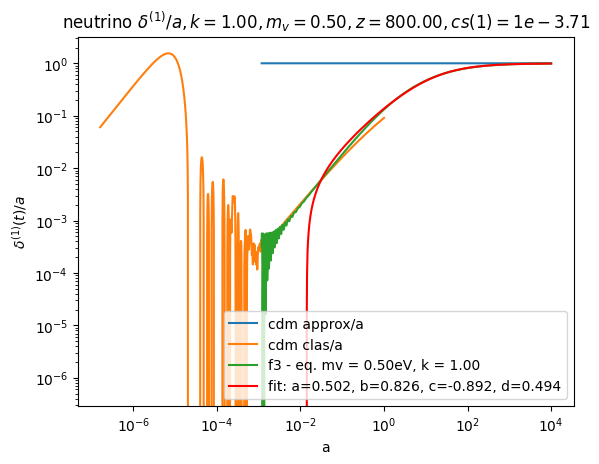

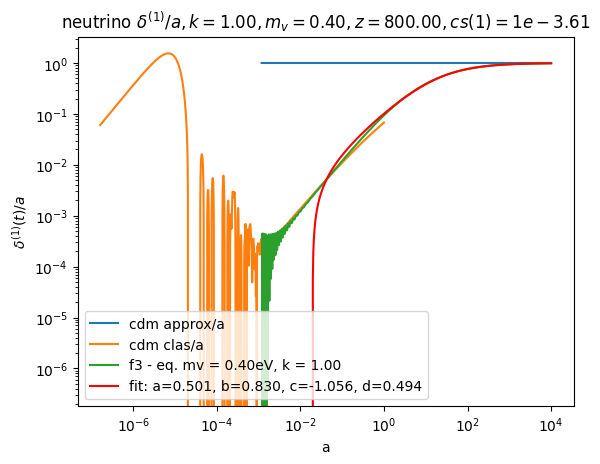

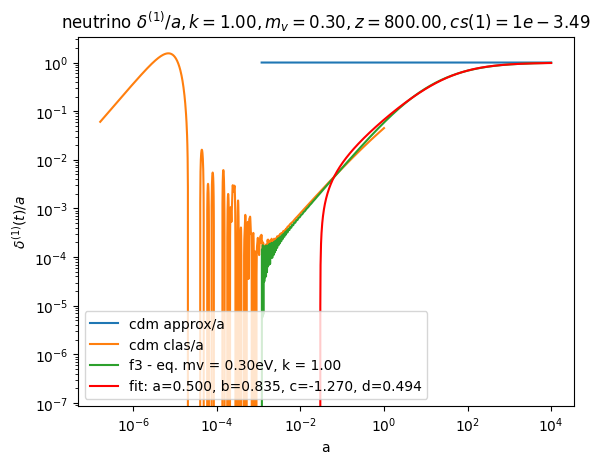

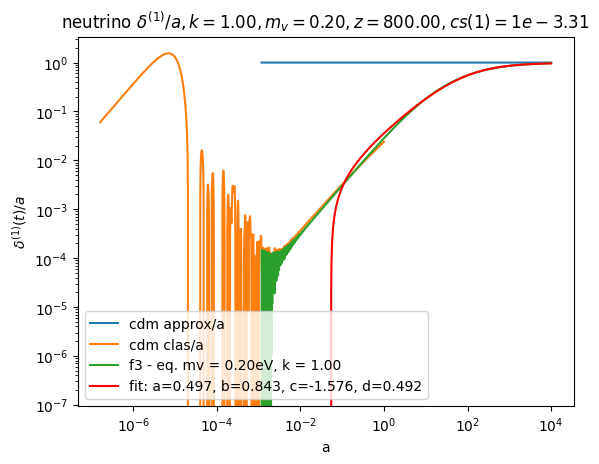

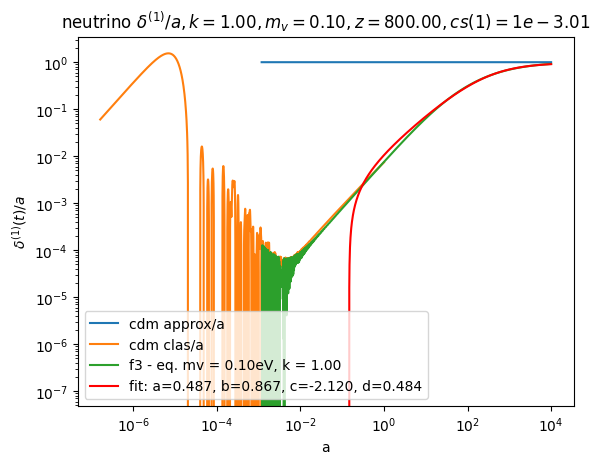

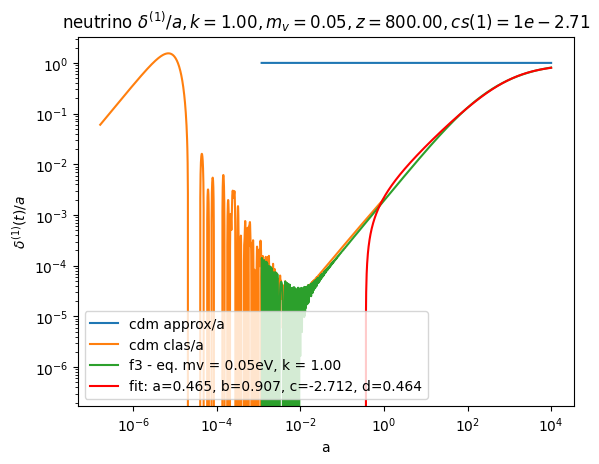

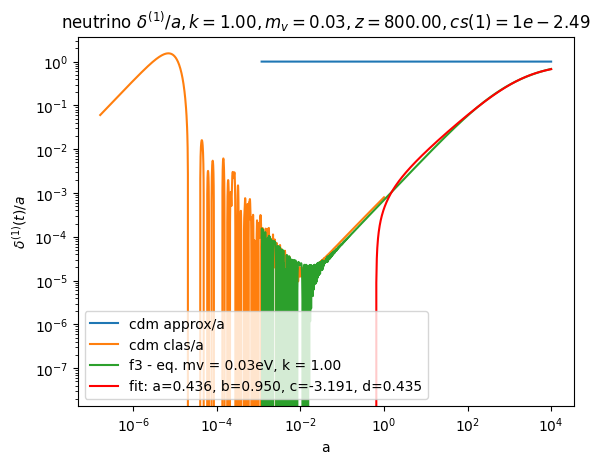

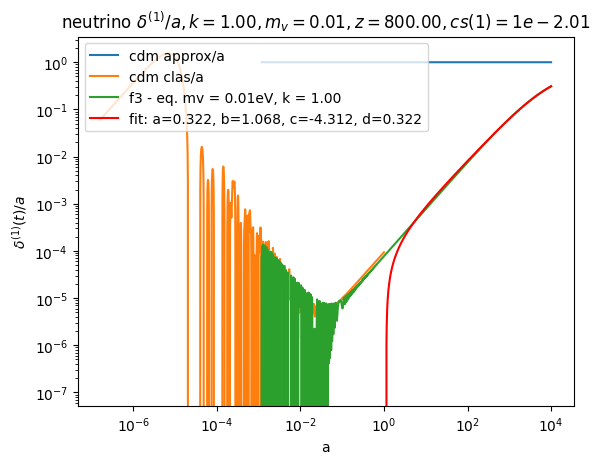

In [68]:
TEST(mv_test=100) 
TEST(mv_test=50) 
TEST(mv_test=10) 
TEST(mv_test=5) 
TEST(mv_test=1) 
TEST(mv_test=0.9) 
TEST(mv_test=0.8) 
TEST(mv_test=0.7) 
TEST(mv_test=0.6) 
TEST(mv_test=0.5) 
TEST(mv_test=.4) 
TEST(mv_test=.3) 
TEST(mv_test=.2) 
TEST(mv_test=.1) 
TEST(mv_test=.05) 
TEST(mv_test=.03) 
TEST(mv_test=.01) 

0.0009738987266769944
numerical goodness_of_fit= 1.6828013265850385e-05


'TEST2(mv_test=.1,H0_override=True,H=50) \nTEST2(mv_test=.1,H0_override=True,H=150)\nTEST2(mv_test=.1,H0_override=True,H=100) \nTEST2(mv_test=.1,H0_override=True,H=20) '

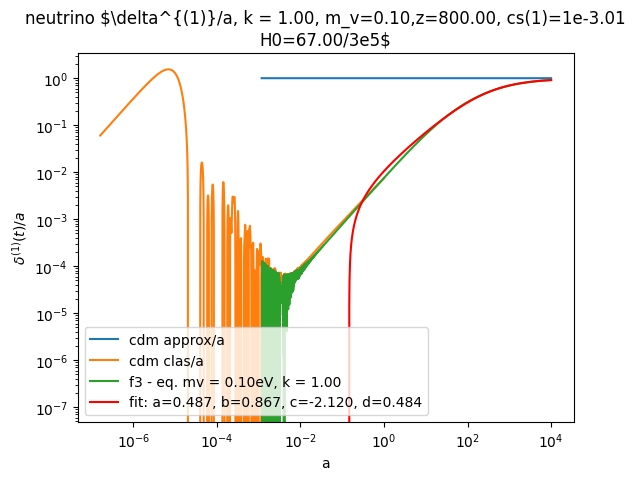

In [22]:
def TEST2(kvec=[1],k_ind=0,z=800,mv_test=1,Omega_M=0.99,
         Omega_b=0.01,PLOT_FIGUR=True,EdSitter=True,
         interpolation_type="cubic",H0_override=False,H=67):

    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    
    H0=67
    
    if H0_override == True:
        H0 =H
    
    # CLASS stuff
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }

    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    c = cs(1)
    print(c)
    def H(a):
        return H0 * np.sqrt(Omega_M /a + Omega_lambda * a**2)    
    
    # henter class data
    #=======================
    
    def simuler(z_slut=0): 
        
        delta_approx = np.empty(len(kvec))
        neu_list     = np.empty(len(kvec)) 
        
        for kind,k in enumerate(kvec): 
            delta_class = pts[kind]["delta_cdm"]
            theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
            delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
            a_class = pts[kind]["a"]
            tau_class = pts[kind]["tau [Mpc]"]
            tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
            interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
            delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
            theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
            neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
            a0 = 1/(1+z)
            aslut = 1/(1+z_slut)
            # så a0 er a start men t0 er tid slut
            t0 = interp_tid_from_a(aslut) 
            #print("2. t0= %s"%t0)
            a_span = [a0,aslut]
            T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
            delta0 = delta_interp(T0)  
            tspan = [T0,t0]        
            def f2(t):
                C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
                C2 = np.pi / 2 * ( 3 * cs(a0) * k * t0 * a0 )**2 * (delta0/a0)
                dcdm = delta0/a0        
                a = (t/t0)**(2/3)
                val = 3 * cs(a) * k * t0 * np.sqrt(a)        
                return dcdm*a+C1*Cos(val)+val**2*a*dcdm*Cos(val)*CosIntegral(val)-C2*Sin(val)+val**2*a*dcdm*Sin(val)*SinIntegral(val) 
            delta_approx[kind] = delta0/a0 * aslut
            neu_list[kind] = f2(t0)
        
        logkvec = np.log10(kvec)
        def p2(delta, k):
            return 2 * np.pi ** 2 * delta**2 *  prim_interp(k) * h**3 *  k**(-3)

        p_approx_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(delta_approx, kvec)), kind=interpolation_type)
        def p_approx(k):
            return 10** p_approx_interp(np.log10(k))


        p_neu_lig_interp = scipy.interpolate.interp1d(logkvec, np.log10(p2(neu_list, kvec)), kind=interpolation_type)
        def p_neu_lig(k):
            return 10** p_neu_lig_interp(np.log10(k))

    
        return p_approx,p_neu_lig
     
    def K(k1,t,theta):
        k2 = k1 * t
        bn = 1
        an = 2/7
        res= (bn - an) + bn/2 *  np.cos(np.pi-theta) * (k2/k1 + k1/k2) + an * (np.cos(np.pi-theta))**2
        return res 
        
    def Bispektrum(k1,t,theta,p):
        k2 = t * k1
        phi = np.pi - theta
        k3 = np.sqrt((k2*np.sin(phi))**2 + (k2*np.cos(phi)+k1)**2)    
        
        # Vi skal også bruge vinklerne mellem k2 og k3 og k3 og k2
        # vinklen mellem k2 og k3:
        theta2 = np.arccos((k3**2 + k2**2 - k1**2) / ( 2 * k3 * k2 )) 
        # vinklen mellem k3 og k1:
        theta3 = np.pi - theta2 - theta
        # vi skal også bruge de forskellige skaleringer 
        t2 = k3/k2
        t3 = k1/k3           
        res =  (2*p(k1)*p(k2)*K(k1,t,theta) +2*p(k3)*p(k1)*K(k3,t3,theta3) +2*p(k2)*p(k3)*K(k2,t2,theta2))
        return res        
    
 
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        # så a0 er a start men t0 er tid slut
        t0 = interp_tid_from_a(aslut)
        #print("2. t0= %s"%t0)
        a_span = [a0,aslut]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]    
        bonus_tid = 1_000_000#_000_000
        #bonus_tid = 1
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),1200)
        def f2(t):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            a = (t/t0)**(2/3)
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) +val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            return res        
        def f3(t):
            H0 = 2/(3*t0)                   
            a = (t/t0)**(2/3)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0             
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
            return res
        
        def f2(a):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) +val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            return res        
        def f3(a):
            H0 = 2/(3*t0)                   
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0             
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
            return res
         
        a_test = (tid_test/t0)**(2/3) 
        fig = plt.figure()
        fig.gca().set_title("neutrino $\delta^{(1)}/a, k = %.2f, m_v=%.2f,z=%.2f, cs(1)=1e%.2f\nH0=%.2f/3e5$" %(kvec[k_ind],mv_test,z,np.log10(cs(1)),H0*3e5))
        #fig.gca().set_xlabel("Physical time [Mpc]")
        fig.gca().set_xlabel("a")
        fig.gca().set_ylabel("$\delta^{(1)}(t)/a$")
        tid_test = np.array(tid_test)
        f4 = np.array(f3(a_test)/(delta0/a0))
        
        """fig.gca().loglog(tid_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(tid_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(tid_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        """
        
        fig.gca().loglog(a_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(a_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(a_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        coordinates = np.vstack([tid_test,f4]).T 
        xdata = a_test
        ydata = f4
        def func(x, a, b, c,d):
            return a * np.tanh(b * x + c) + d
        #plt.plot(xdata, ydata, 'b-', label='data')
        p0 = np.array([-0.5,-.5,cs(1),1])#0.502])
        popt, pcov = curve_fit(func, np.log10(xdata), (ydata))#,p0=p0)
        #popt[-1] += 1e-4
        #plt.loglog(xdata, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.loglog(a_test, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        goodness_of_fit = np.mean((ydata- func(np.log10(xdata), *popt))**2)
        print("numerical goodness_of_fit= %s" % goodness_of_fit)
        #goodness_of_fit = np.mean((ydata- func(np.log10(xdata), *[]))**2)
        plt.legend() 
    test(0)
    

TEST2(mv_test=.1)
"""TEST2(mv_test=.1,H0_override=True,H=50) 
TEST2(mv_test=.1,H0_override=True,H=150)
TEST2(mv_test=.1,H0_override=True,H=100) 
TEST2(mv_test=.1,H0_override=True,H=20) """

numerical goodness_of_fit= 0.0005307171974105157
numerical goodness_of_fit= 0.0005337864667489407
numerical goodness_of_fit= 0.0005352341426509621
numerical goodness_of_fit= 0.0005352960871553245
numerical goodness_of_fit= 0.0005367058561686297
numerical goodness_of_fit= 0.0005347136193511221
numerical goodness_of_fit= 0.0005352573456708353
numerical goodness_of_fit= 0.0005354619310434552
numerical goodness_of_fit= 0.0005354699002941018
numerical goodness_of_fit= 0.0005372702904929419


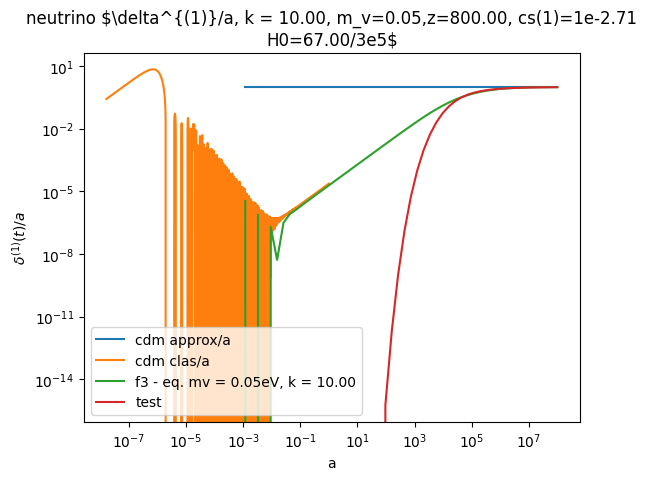

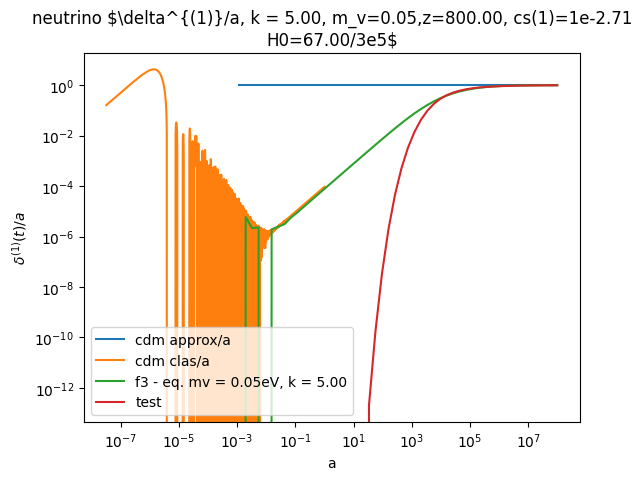

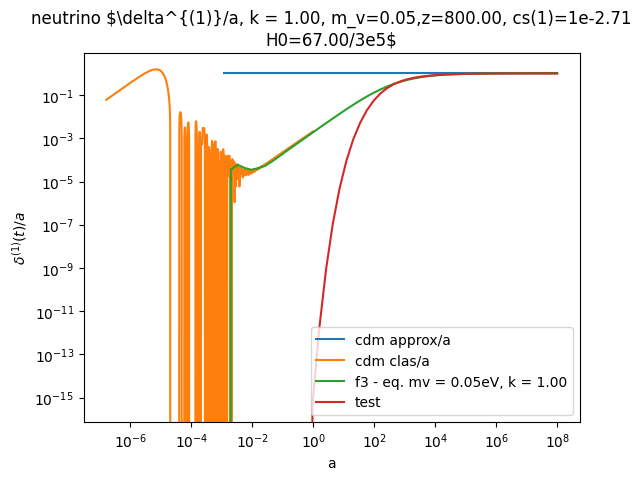

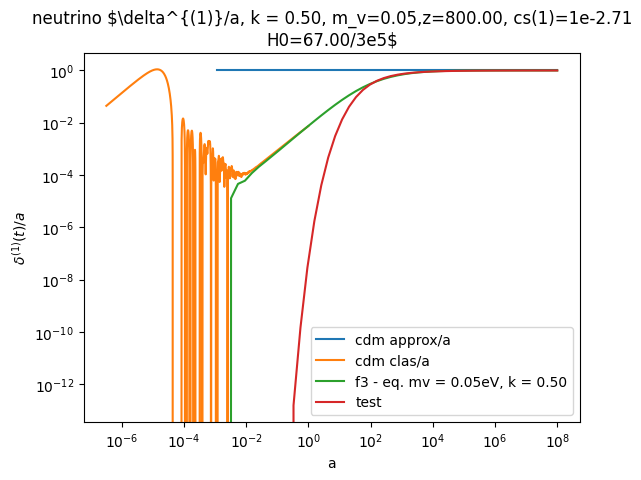

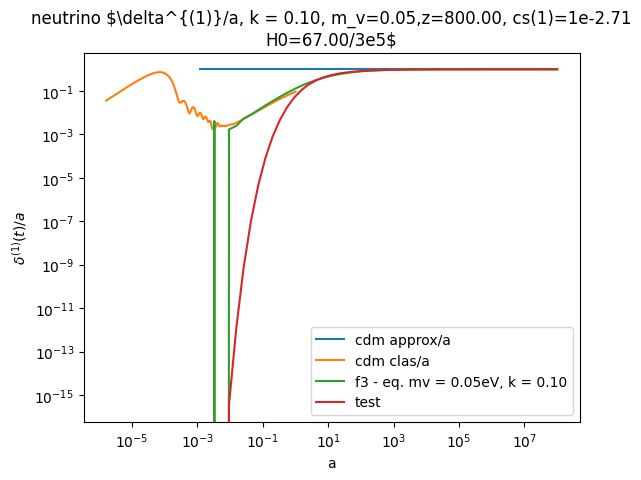

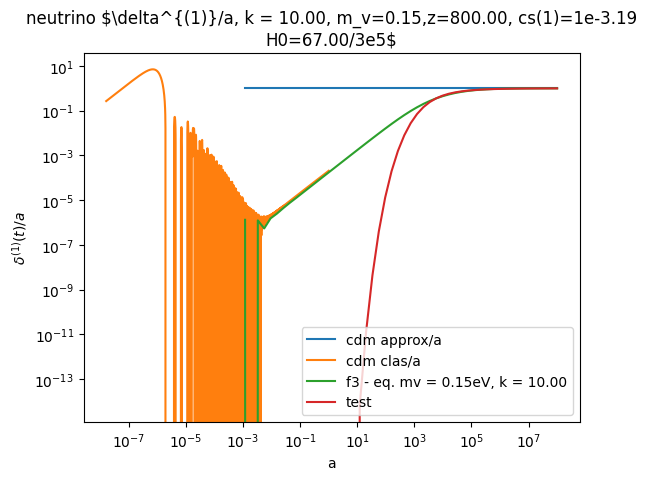

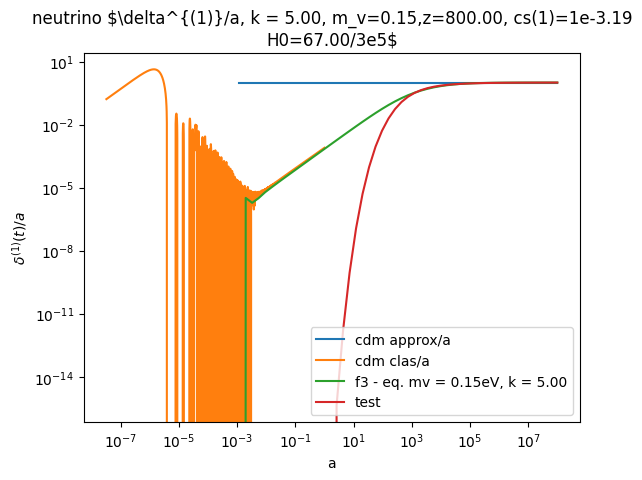

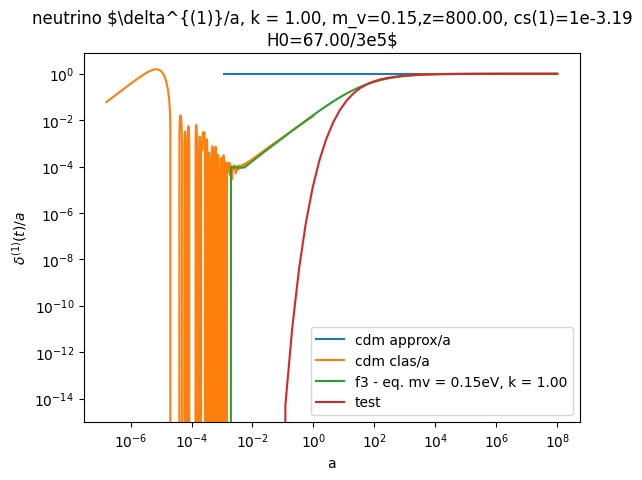

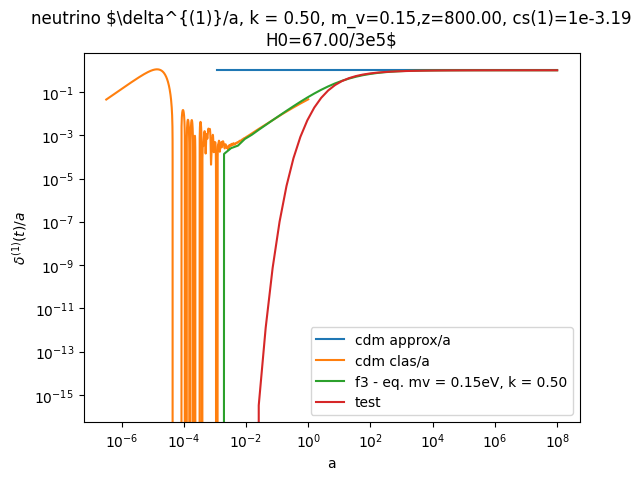

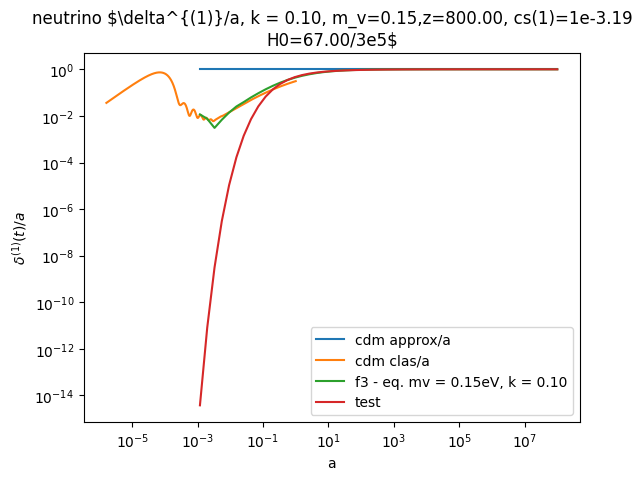

In [125]:
def TEST6(kvec=[1],k_ind=0,z=800,mv_test=1,Omega_M=0.99,
         Omega_b=0.01,PLOT_FIGUR=True,EdSitter=True,
         interpolation_type="cubic",H0_override=False,H=67):
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    H0=67
    if H0_override == True:
        H0 =H
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    c = cs(1)
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        t0 = interp_tid_from_a(aslut)
        a_span = [a0,aslut]
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        tspan = [T0,t0]    
        bonus_tid = 1_000_000_000_000
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),50)
        def f2(a):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) +val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            return res        
        def f3(a):
            H0 = 2/(3*t0)                   
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0             
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
            return res
        a_test = (tid_test/t0)**(2/3) 
        fig = plt.figure()
        fig.gca().set_title("neutrino $\delta^{(1)}/a, k = %.2f, m_v=%.2f,z=%.2f, cs(1)=1e%.2f\nH0=%.2f/3e5$" %(kvec[k_ind],mv_test,z,np.log10(cs(1)),H0*3e5))
        fig.gca().set_xlabel("a")
        fig.gca().set_ylabel("$\delta^{(1)}(t)/a$")
        tid_test = np.array(tid_test)
        f4 = np.array(f3(a_test)/(delta0/a0))
        fig.gca().loglog(a_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(a_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(a_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        coordinates = np.vstack([tid_test,f4]).T 
        xdata = a_test
        ydata = f4
        def func(x, a, b, c,d):
            return a * np.tanh(b * x + c) + d
        p0 = np.array([-0.5,-.5,cs(1),1])#0.502])
        popt, pcov = curve_fit(func, np.log10(xdata), (ydata))#,p0=p0)
        #plt.loglog(a_test, func(np.log10(xdata), *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        Val = 2 * cs(a_test) * np.sqrt(a_test) * k / H0
        y = 1+ np.tanh(-Val)
        plt.loglog(a_test,y,label="test")
        goodness_of_fit = np.mean((ydata- y)**2)
        print("numerical goodness_of_fit= %s" % goodness_of_fit)
        #goodness_of_fit_log = np.mean((np.log(ydata+1)- np.log(func(np.log10(xdata), *popt)+1))**2)
        #print("numerical goodness_of_fitLog= %s" % goodness_of_fit_log)
        plt.legend() 
        res =  np.array([kvec[kind],H0,delta0,a0,cs(a0),neu_tid(T0),theta_neu_tid(T0)])
        return res, a_test, f4, t0 
    res, a_test, f5,t0 = test(0)
    return res, a_test, f5,t0
res, a_test, f5,t0 =TEST6(kvec=[10],mv_test=0.05)
res, a_test, f5,t0 =TEST6(kvec=[5],mv_test=0.05)
res, a_test, f5,t0 =TEST6(kvec=[1],mv_test=0.05)
res, a_test, f5,t0 =TEST6(kvec=[0.5],mv_test=0.05)

res, a_test, f5,t0 =TEST6(kvec=[0.1],mv_test=0.05)


res, a_test, f5,t0 =TEST6(kvec=[10],mv_test=0.15)
res, a_test, f5,t0 =TEST6(kvec=[5],mv_test=0.15)
res, a_test, f5,t0 =TEST6(kvec=[1],mv_test=0.15)
res, a_test, f5,t0 =TEST6(kvec=[0.5],mv_test=0.15)

res, a_test, f5,t0 =TEST6(kvec=[0.1],mv_test=0.15)

a = np.array(a_test,dtype=np.complex_)
f5 = np.array(f5,dtype=np.complex_)
k, H0, delta0,a0,cs_a0,delta_neuT0,theta_neuT0 = res
mv_test=0.1
# cs_a,k,H0,delta0,a0,cs_a0 

0.00022333333333333333
0.7800928800682724
0.1


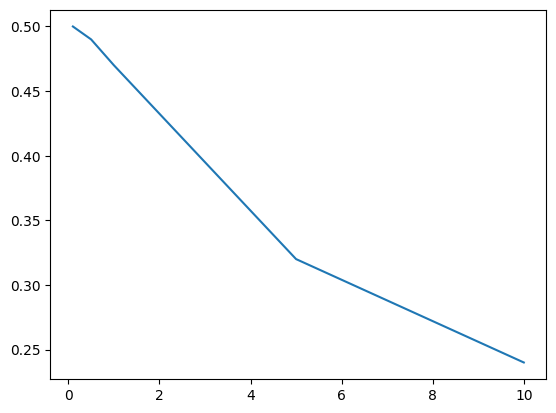

In [108]:
print(H0)
print(cs(a0))
print(k)

kl = [.1,.5,1,5,10]
Al = [0.5,0.49,0.47,0.32,0.24]
plt.plot(kl,Al)

In [109]:
N = len(a_test)
def f4(a):
    H0 = 2/(3*t0)                   
    C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
    C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
    dcdm = delta0/a0             
    val = 2 * cs(a) * k  * np.sqrt(a) / H0
    EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
    res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
    return res/(delta0/a0)

2
1
0
12822.249022006989
(0.0001312880476824699+0j)


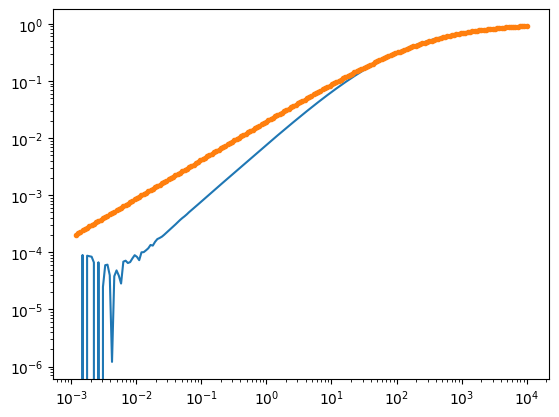

In [113]:
"""#potens_list = np.array([-2,-1, -0.5,0,0.5,1,2])
potens_list = np.array([2,1,0])

def test_func(a,B,C,D):
    return 1/2 * ( np.tanh(B * np.log10(C*a) + D) + 1)
Best_Error = None
t1 = time()


for b1 in potens_list:
    print(b1)
    for b2 in potens_list:
        for b3 in potens_list:
            for b4 in potens_list:
                for b5 in potens_list:
                    for b6 in potens_list:
                        for c1 in potens_list:
                            for c2 in potens_list:
                                for c3 in potens_list:
                                    for c4 in potens_list:
                                        for c5 in potens_list:
                                            for c6 in potens_list:
                                                for d1 in potens_list:
                                                    for d2 in potens_list:
                                                        for d3 in potens_list:
                                                            for d4 in potens_list:
                                                                for d5 in potens_list:
                                                                    for d6 in potens_list:
                                                                        for i in [0,1]:
                                                                            B = k ** b1 * H0 ** b2 * delta0 ** b3 *a0**b4 * cs_a0 ** b5 #* a** b6
                                                                            C = k ** c1 * H0 ** c2 * a0**c4 * cs_a0 ** c5 #* delta0 ** c3
                                                                            D = k ** d1 * H0 ** d2 * delta0 ** d3 *a0**d4 * cs_a0 ** d5
                                                                            res = np.mean((test_func(a_test,B,C,(-1) ** i *D) - f5)**2)
                                                                            error = res
                                                                            if Best_Error == None or error < Best_Error :
                                                                                Best_Error = error
                                                                                coordinates = np.array([b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,i])
t2 = time()
print(t2-t1)
gy = 4

print(Best_Error)     
b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,i = coordinates
B = k ** b1 * H0 ** b2 * delta0 ** b3 *a0**b4 * cs_a0 ** b5 #* a** b6
C = k ** c1 * H0 ** c2 * a0**c4 * cs_a0 ** c5 #* delta0 ** c3
D = k ** d1 * H0 ** d2 * delta0 ** d3 *a0**d4 * cs_a0 ** d5"""


In [110]:
coordinates = [2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0]
Best_Error = 0.0001312880476824699
print(coordinates)
print(coordinates[0:6])
print(coordinates[6:12])
print(coordinates[12:18])
print(coordinates[-1])
print(Best_Error) 

b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,i = coordinates
B = k ** b1 * H0 ** b2 * delta0 ** b3 *a0**b4 * cs_a0 ** b5 #* a** b6
C = k ** c1 * H0 ** c2 * a0**c4 * cs_a0 ** c5 #* delta0 ** c3

D = k ** d1 * H0 ** d2 * delta0 ** d3 *a0**d4 * cs_a0 ** d5
if i == 1:
    D *= -1
print(B,C,D)
#b5 = 1, c2 = 1, c5 = 1,
B = cs_a0
C = H0
D = 1 
print(len(coordinates))

[2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0]
[2, 0, 0, 0, 1, 2]
[2, 2, 2, 1, 0, 2]
[2, 1, 2, 0, 2, 2]
0
0.0001312880476824699
0.01560185760136545 6.226938549035929e-13 0.0066168766006227155
19


0.00022333333333333333


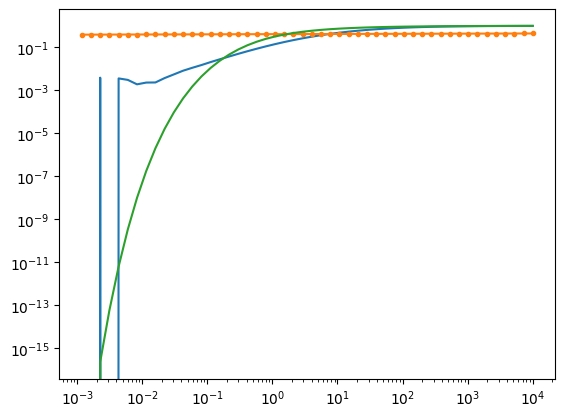

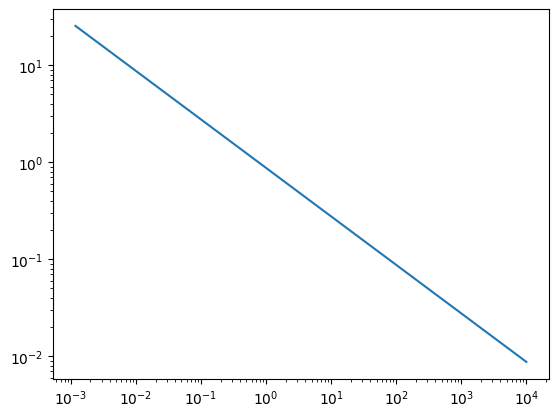

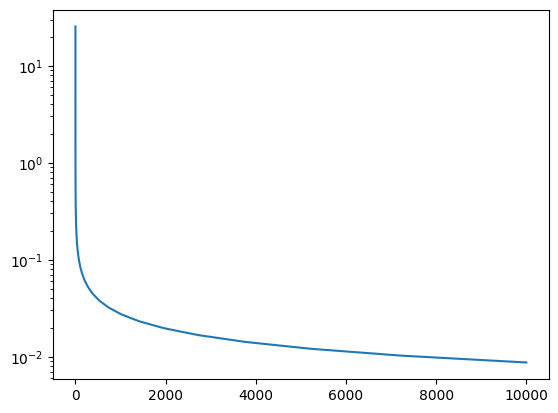

In [120]:
#
H0 = 67/(3*1e5)
b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,i = coordinates
B = k ** b1 * H0 ** b2 * delta0 ** b3 *a0**b4 * cs_a0 ** b5 #* a** b6
C = k ** c1 * H0 ** (c2) * a0**c4 * cs(a0) ** c5 #* delta0 ** c3

D = k ** d1 * H0 ** d2 * delta0 ** d3 *a0**d4 * cs_a0 ** d5

def test_func(a,B,C,D):
    return 1/2 * ( np.tanh(B * np.log10(C*a) + D) + 1)
plt.loglog(a_test,f5)
plt.loglog(a_test,test_func(a_test,B,C,D),".-")
print(H0)

b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,i = coordinates
B = k ** b1 * H0 ** b2 * delta0 ** b3 *a0**b4 * cs(a0)  ** b5 #* a** b6
C = k ** c1 * H0 ** (c2) * a0**c4 * cs(a0) ** c5 #* delta0 ** c3
#print(f"{cs(a_test)=}")
D = k ** d1 * H0 ** d2 * delta0 ** d3 *a0**d4 * cs(a0)  ** d5

def test_func(a,B,C,D):
    return 1/2 * ( np.tanh(B * np.log10(C*a) + D) + 1)

#plt.loglog(a_test,test_func(a_test,B,C,D),".-")
Val = 2 * cs(a_test) * np.sqrt(a_test) * k / H0
plt.loglog(a_test,1+np.tanh(-Val))
plt.figure()
plt.loglog(a_test,Val)
plt.figure()
plt.plot(a_test,Val)
plt.yscale("log")

0.6366196513075943


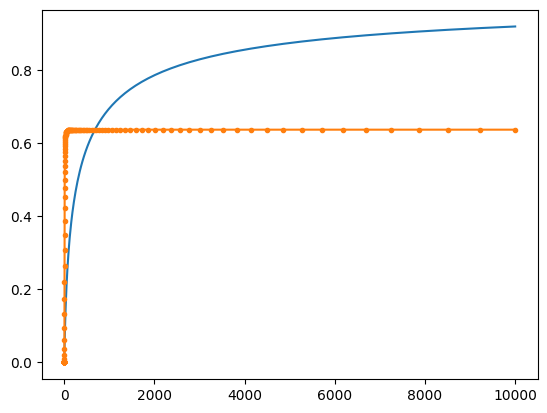

In [91]:
plt.plot(a_test,f5)
def test_func1(a,A,B,C):
    return   ( 1+ A*np.tanh(B*a+C))
def f(a):
    return 2/np.pi * ( 1 - np.tanh(k**2 * cs(a)**2/H0**2  ))

def g(a):
    return 1/ ( 1+ np.exp(-np.log(a)*k**2*cs(a) /delta0))
print(f(a_test[-1]))

#plt.loglog(a_test,test_func1(a_test,B,C,D),".-")
plt.plot(a_test,f(a_test),".-")
#plt.plot(a_test,g(a_test),".-")

In [27]:
print(coordinates)
Best_Error = 0.0001312880476824699
print(len(coordinates))
#print(f5)

[2, 0, 0, 0, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0]
19


In [113]:
#print(f5**0.5)


In [29]:
13.4/0.001

13400.0

In [30]:
Ainv = np.linalg.inv(np.matrix([[1,1],[2,1]]))
print(Ainv)
y = np.array([0.001,13.4]).T
print(Ainv@y)

[[-1.  1.]
 [ 2. -1.]]
[[ 13.399 -13.398]]


In [112]:
Z = np.zeros((3,3,3,3,3,3,3,3,3,3,3,3,3))
#Z

0
1
2
24.47191333770752
(0.02663208472029351+0j)


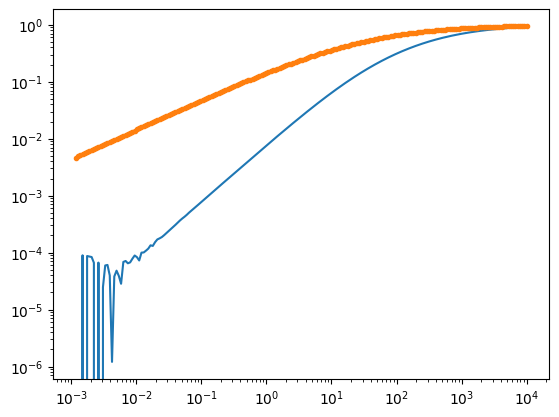

In [107]:
"""#potens_list = np.array([-2,-1, -0.5,0,0.5,1,2])
potens_list = np.array([0,1,2])

def test_func(a,B,C,D):
    return 1/2 * ( np.tanh(B * np.log10(C*a) + D) + 1)
Best_Error = None
t1 = time()


for b1 in potens_list:
    print(b1)
    for b2 in potens_list:
        for b3 in potens_list:
            for b4 in potens_list:
                for b5 in potens_list:
                    for b6 in potens_list:
                        for d1 in potens_list:
                            for d2 in potens_list:
                                for d3 in potens_list:
                                    for d4 in potens_list:
                                        for d5 in potens_list:
                                            for d6 in potens_list:
                                                for i in [0,1]:
                                                    B = k ** b1 * H0 ** b2 * delta0 ** b3 *a0**b4 * cs_a0 ** b5 #* a** b6
                                                    #C = k ** c1 * H0 ** c2 * a0**c4 * cs_a0 ** c5 #* delta0 ** c3
                                                    D = k ** d1 * H0 ** d2 * delta0 ** d3 *a0**d4 * cs_a0 ** d5
                                                    res = np.mean((test_func(a_test,B,1,(-1) ** i *D) - f5)**2)
                                                    error = res
                                                    if Best_Error == None or error < Best_Error :
                                                        Best_Error = error
                                                        coordinates = np.array([b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,i])
t2 = time()
print(t2-t1)
gy = 4
print(Best_Error)     
b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,i = coordinates
B = k ** b1 * H0 ** b2 * delta0 ** b3 *a0**b4 * cs_a0 ** b5 #* a** b6
C = k ** c1 * H0 ** c2 * a0**c4 * cs_a0 ** c5 #* delta0 ** c3
D = k ** d1 * H0 ** d2 * delta0 ** d3 *a0**d4 * cs_a0 ** d5

plt.loglog(a_test,f5)
plt.loglog(a_test,test_func(a_test,B,C,D),".-")"""